# Twitter data analysis

This notebook covers some of the basic investigations around the Twitter data that is being collected with the `ingress` tool. This is not meant to replace the web application that will be built, but is rather used as a complimentary exploration tool.

In [1]:
import sqlite3
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# The config is one level above the notebook folder.
config = configparser.ConfigParser()
config.read('../service.cfg')
config.sections()

userId = '47547933' # Myself (Den Delimarsky)
#userId = '11768582' # Garry Tan
#userId = '3356531254' # Internet of Shit

In [3]:
# Using relative path here because the database is one level above the notebook folder.
data_connection = sqlite3.connect("../" + config['Datastore']['Database'])

In [4]:
#cursor = data_connection.cursor()

## Top tweets
A general breakdown of some of the most impactful tweets, by the volume of interactions

In [5]:
statement = f'SELECT text, likes, retweets, replies, time_of_tweet FROM tweets WHERE author_id = "{userId}" ORDER BY likes DESC'
df = pd.read_sql_query(statement, data_connection)
df.head(5)

,text,likes,retweets,replies,time_of_tweet
0,You can run a blog on GitHub Pages for free an...,463,60,12,2020-03-31T03:36:40+00:00
1,Really excited to announce that today we've la...,414,175,8,2020-01-27T21:56:12+00:00
2,"""Oh you're remote? So do you watch Netflix all...",349,47,9,2020-02-24T05:56:31+00:00
3,More of us are working remotely. Here are some...,260,65,1,2020-03-05T03:39:55+00:00
4,A crucial mistake that a lot of product manage...,147,45,3,2020-03-01T01:26:03+00:00


## Aggregate popularity by date and time (Retweets)

In [6]:
statement = f"""SELECT sum(retweets) retweets, strftime('%Y-%m-%d', local_time) tweet_date, strftime('%H:00', local_time) tweet_hour FROM (
	SELECT time_of_tweet, retweets, datetime(time_of_tweet, 'localtime') local_time FROM tweets 
	WHERE author_id='{userId}'
		AND text NOT LIKE 'RT @%'
	ORDER BY retweets DESC)
GROUP BY tweet_date, tweet_hour"""
df = pd.read_sql_query(statement, data_connection)
# df.head(20)

pivoted_df = df.pivot(index='tweet_hour', columns='tweet_date', values='retweets')
pivoted_df = pivoted_df.replace(np.nan,0)
pivoted_df.style.background_gradient(cmap='Blues')

#pivoted_df.head(10)

#sns.heatmap(pivoted_df, annot=True)

## Aggregate tweet popularity by day and time (Retweets)

In this context, we want to study at what times and on what dates tweets get the most traction. This is a variant of the implementation above with the data frame.

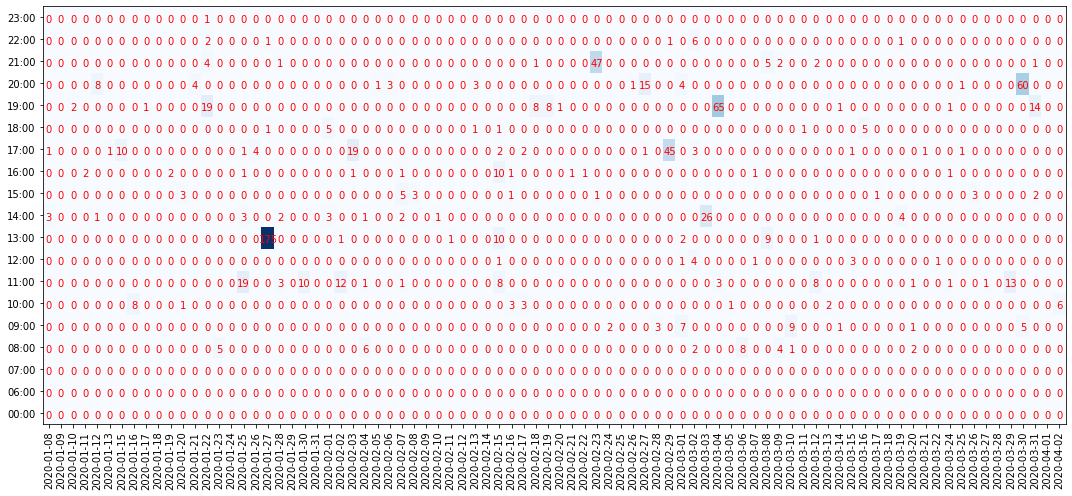

In [7]:
fig, ax = plt.subplots(figsize=(15,7))

for i in range(len(pivoted_df.index)):
    for j in range(len(pivoted_df.columns)):
        #text = ax.text(j, i, pivoted_df.iat[i, j], ha="left", va="bottom", color="red")
        text = ax.text(j+ 0.5, i+0.4, int(pivoted_df.iat[i, j]), ha="center", va="center", color="red")

# See color maps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
plt.set_cmap('Blues')
#plt.figure(figsize=(12,7))
plt.pcolor(pivoted_df)
plt.yticks(np.arange(0.5, len(pivoted_df.index), 1), pivoted_df.index)
plt.xticks(np.arange(0.5, len(pivoted_df.columns), 1), pivoted_df.columns, rotation='vertical')
fig.tight_layout()
plt.show()

In [8]:
statement = f"""SELECT sum(retweets) retweets, case cast (strftime('%w', local_time) as integer)
  when 0 then 'Sunday'
  when 1 then 'Monday'
  when 2 then 'Tuesday'
  when 3 then 'Wednesday'
  when 4 then 'Thursday'
  when 5 then 'Friday'
  else 'Saturday' end as day_of_week, strftime('%H:00', local_time) tweet_hour FROM (
	SELECT time_of_tweet, retweets, datetime(time_of_tweet, 'localtime') local_time FROM tweets 
	WHERE author_id='{userId}'
		AND text NOT LIKE 'RT @%'
	ORDER BY retweets DESC)
GROUP BY day_of_week, tweet_hour"""
df = pd.read_sql_query(statement, data_connection)
# df.head(20)

pivoted_df = df.pivot(index='tweet_hour', columns='day_of_week', values='retweets')
pivoted_df = pivoted_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
pivoted_df = pivoted_df.replace(np.nan,0)
pivoted_df.style.background_gradient(cmap='Blues')

#pivoted_df.head(10)

#sns.heatmap(pivoted_df, annot=True)

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
tweet_hour,,,,,,,
00:00,0,0,0,0,0,0,0
06:00,0,0,0,0,0,0,0
07:00,0,0,0,0,0,0,0
08:00,6,7,0,5,10,0,0
09:00,7,9,0,0,4,1,7
10:00,4,0,0,15,2,0,3
11:00,0,5,3,18,3,27,25
12:00,4,0,0,0,0,2,5
13:00,175,1,0,1,0,10,12


In [9]:
statement = f"""SELECT sum(likes) likes, case cast (strftime('%w', local_time) as integer)
  when 0 then 'Sunday'
  when 1 then 'Monday'
  when 2 then 'Tuesday'
  when 3 then 'Wednesday'
  when 4 then 'Thursday'
  when 5 then 'Friday'
  else 'Saturday' end as day_of_week, strftime('%H:00', local_time) tweet_hour FROM (
	SELECT time_of_tweet, likes, datetime(time_of_tweet, 'localtime') local_time FROM tweets 
	WHERE author_id='{userId}'
		AND text NOT LIKE 'RT @%'
	ORDER BY likes DESC)
GROUP BY day_of_week, tweet_hour"""
df = pd.read_sql_query(statement, data_connection)

pivoted_df = df.pivot(index='tweet_hour', columns='day_of_week', values='likes')
pivoted_df = pivoted_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
pivoted_df = pivoted_df.replace(np.nan,0)
pivoted_df.style.background_gradient(cmap='Blues')

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
tweet_hour,,,,,,,
00:00,0,0,3,0,0,6,0
06:00,3,0,0,0,5,0,0
07:00,0,5,0,0,0,0,0
08:00,43,47,0,21,50,0,0
09:00,41,23,3,9,15,36,38
10:00,19,0,14,39,15,2,52
11:00,0,33,51,143,53,118,114
12:00,28,2,4,8,32,36,40
13:00,414,4,1,6,3,99,50


# Most frequent tweet times

In [10]:
statement = f"""SELECT count(*) total_tweets, case cast (strftime('%w', local_time) as integer)
  when 0 then 'Sunday'
  when 1 then 'Monday'
  when 2 then 'Tuesday'
  when 3 then 'Wednesday'
  when 4 then 'Thursday'
  when 5 then 'Friday'
  else 'Saturday' end as day_of_week, strftime('%H:00', local_time) tweet_hour FROM (
	SELECT time_of_tweet, datetime(time_of_tweet, 'localtime') local_time FROM tweets 
	WHERE author_id='{userId}'
		AND text NOT LIKE 'RT @%'
	ORDER BY time_of_tweet DESC)
GROUP BY day_of_week, tweet_hour"""
df = pd.read_sql_query(statement, data_connection)

pivoted_df = df.pivot(index='tweet_hour', columns='day_of_week', values='total_tweets')
pivoted_df = pivoted_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
pivoted_df = pivoted_df.replace(np.nan,0)
pivoted_df.style.background_gradient(cmap='Blues')

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
tweet_hour,,,,,,,
00:00,0,0,10,0,0,1,0
06:00,1,0,0,0,1,0,0
07:00,0,2,0,0,0,0,0
08:00,3,7,1,4,4,0,0
09:00,5,6,1,6,2,6,2
10:00,5,0,4,8,3,2,1
11:00,0,17,5,9,7,10,10
12:00,5,2,4,5,6,19,10
13:00,1,1,1,3,2,4,16


## Fluctuations in followers and following users

In [11]:
statement = f'SELECT follower_count, following_count, time_of_capture FROM user_snapshots WHERE user_id = "{userId}"'
df = pd.read_sql_query(statement, data_connection)
df.head(20)

,follower_count,following_count,time_of_capture
0,6620,500,2020-01-18T14:43:32
1,6620,500,2020-01-18T15:31:10
2,6620,500,2020-01-18T15:32:33
3,6620,500,2020-01-18T15:33:13
4,6620,500,2020-01-18T15:34:37
5,6620,500,2020-01-18T15:37:54
6,6620,500,2020-01-18T15:38:46
7,6620,500,2020-01-18T15:41:43
8,6620,500,2020-01-18T15:42:44
9,6620,500,2020-01-18T15:44:31


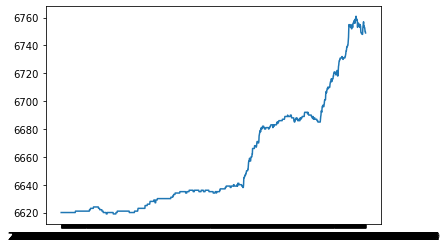

In [12]:

plt.plot(df.time_of_capture, df.follower_count)

In [13]:
statement = f"""SELECT * FROM (
SELECT 
	last_value(follower_count) 
	OVER (
		PARTITION BY target_date
	) followers,
	last_value(following_count) 
	OVER (
		PARTITION BY target_date
	) following,
	target_date
FROM (
	SELECT
		strftime('%Y-%m-%d', time_of_capture) target_date,
		following_count,
		follower_count
	FROM
		(SELECT
			*
		FROM
			user_snapshots
		WHERE
			user_id = '{userId}'
		ORDER BY time_of_capture))
) GROUP BY target_date, followers, following
"""
df = pd.read_sql_query(statement, data_connection)
df.head()

,followers,following,target_date
0,6620,500,2020-01-18
1,6623,500,2020-01-19
2,6621,500,2020-01-20
3,6626,500,2020-01-21
4,6634,500,2020-01-22


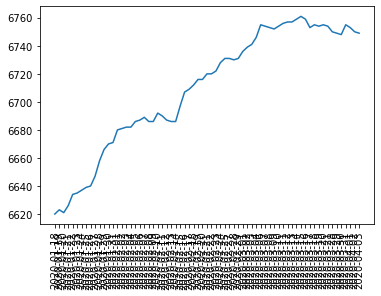

In [14]:
plt.xticks(rotation='vertical')
plt.plot(df.target_date, df.followers)

# Monthly tweet volume

In [15]:
statement = f"""SELECT count(*) total_tweets, strftime("%m-%Y", time_of_tweet) aggregatedate  FROM (
	SELECT time_of_tweet FROM tweets 
	WHERE author_id='{userId}'
		AND text NOT LIKE 'RT @%'
	ORDER BY time_of_tweet DESC)
GROUP BY aggregatedate"""
df = pd.read_sql_query(statement, data_connection)
df.head()

,total_tweets,aggregatedate
0,158,01-2020
1,216,02-2020
2,191,03-2020
3,12,04-2020


<BarContainer object of 4 artists>

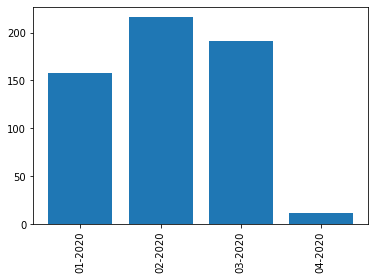

In [16]:
plt.xticks(rotation='vertical')
plt.bar(df.aggregatedate, df.total_tweets)